In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil import parser
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

data = pd.read_csv("data/tidy_data/new_jump_data.csv")

In [2]:
def prepare_data(df):
    date_columns = ['Date', 'problem_date', 'return_date', 'reported_date']

    df = df.dropna(subset=date_columns)

    for col in date_columns:
        df.loc[:,col] = [parser.parse(date) for date in df[col]]

    df = df.sort_values('Date')
    
    # Create injury indicator (1 if injury occurred within next 14 days)
    df['next_injury'] = 0
    for idx, row in df.iterrows():
        future_injuries = df[
            (df['problem_date'] > row['Date']) & 
            (df['problem_date'] <= row['Date'] + pd.Timedelta(days=14))
        ]
        if len(future_injuries) > 0:
            df.at[idx, 'next_injury'] = 1
    
    return df

def create_features(df):
    exclude_cols = ['Date', 'problem_date', 'return_date', 'reported_date', 
                    'next_injury', 'athlete_code', 'TestId']
    feature_cols = [col for col in df.columns if col not in exclude_cols and 
                   df[col].dtype in ['float64', 'int64']]
    
    X = df[feature_cols].ffill().replace([np.inf, -np.inf], np.nan).fillna(0)
    y = df['next_injury']
    
    return X, y, feature_cols

def train_and_evaluate(X, y):
    tscv = TimeSeriesSplit(n_splits=5)

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    
    feature_importances = []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        if np.isnan(X_train_scaled).any() or np.isnan(X_test_scaled).any():
            X_train_scaled = np.nan_to_num(X_train_scaled)
            X_test_scaled = np.nan_to_num(X_test_scaled)
        
        rf.fit(X_train_scaled, y_train)

        feature_importances.append(rf.feature_importances_)
    
    mean_importances = np.mean(feature_importances, axis=0)
    
    return mean_importances

def plot_feature_importance(importances, feature_names, top_n=20):
    feat_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    feat_imp = feat_imp.sort_values('Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feat_imp)
    plt.title(f'Top {top_n} Most Important Features for Injury Prediction')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    
    return feat_imp

# Ensemble Model (Random Forest 20%, XGBoost 50% with L1 penalization, LightGBM 30%)

Class distribution:
next_injury
0    0.716931
1    0.283069
Name: proportion, dtype: float64

Overall Metrics:
Mean AUC: 0.575 ± 0.046
Mean PR-AUC: 0.344 ± 0.230
Mean Positive Ratio: 0.317


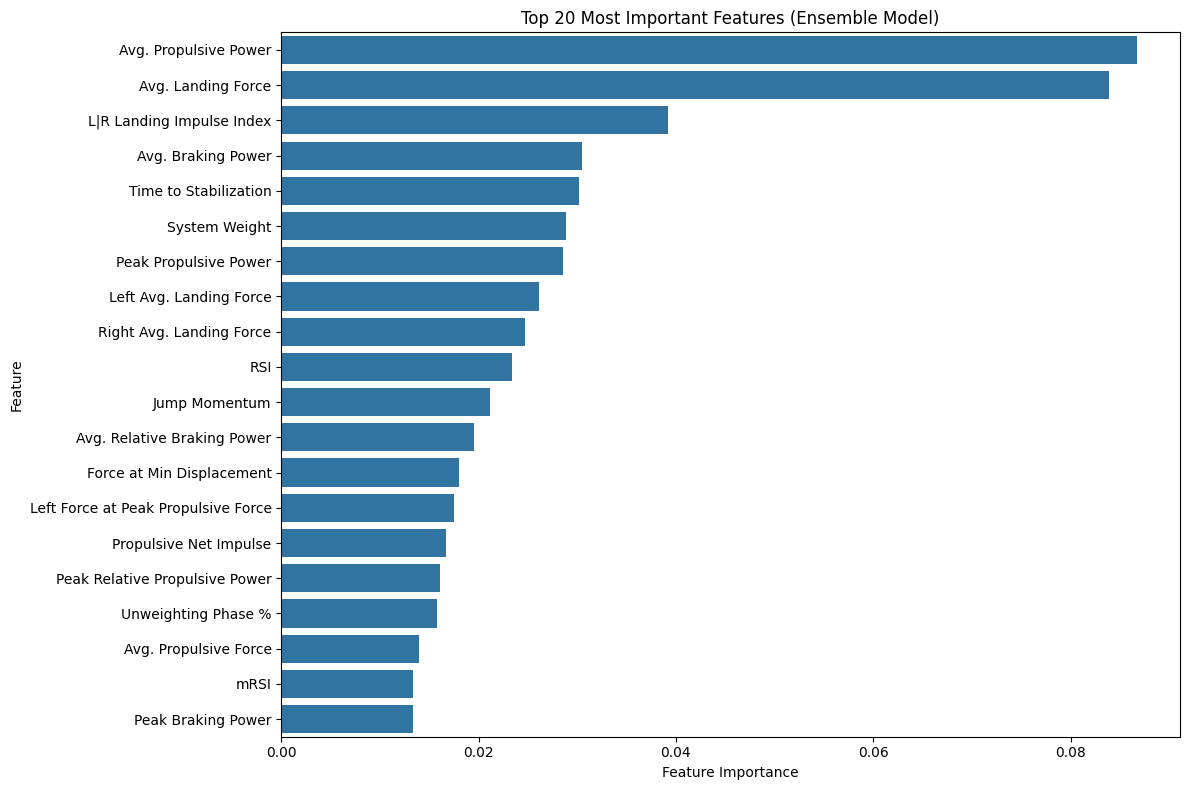

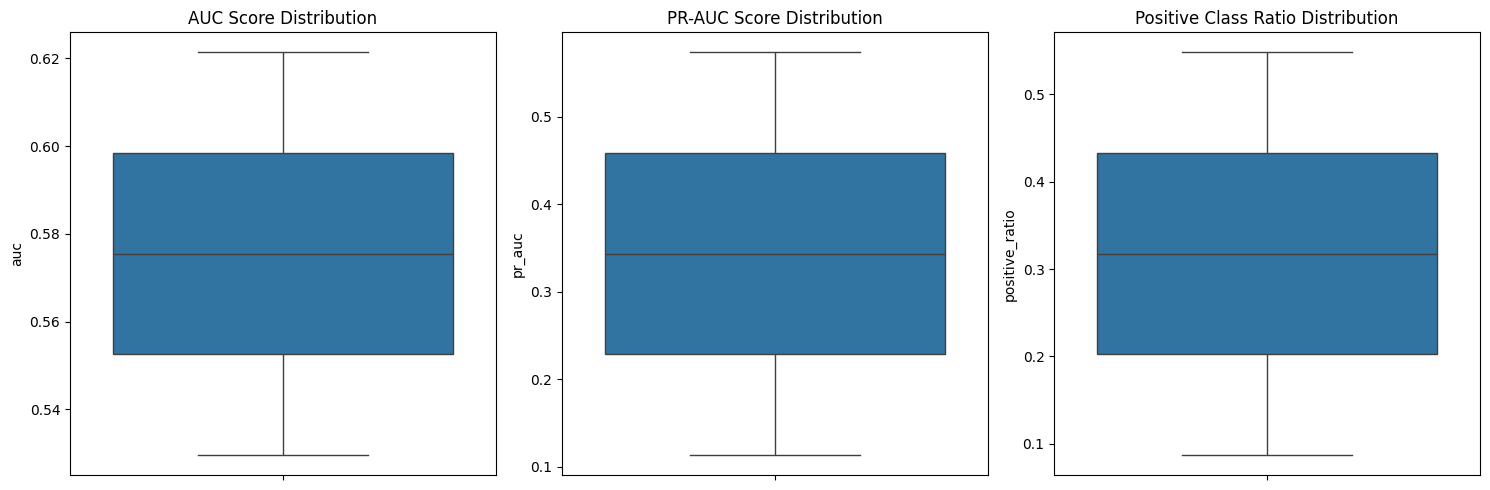

In [3]:
def prepare_data(df):
    date_columns = ['Date', 'problem_date', 'return_date', 'reported_date']
    df = df.dropna(subset=date_columns)
    
    for col in date_columns:
        df.loc[:,col] = [parser.parse(date) for date in df[col]]
    
    df = df.sort_values('Date')
    
    df['next_injury'] = 0
    for idx, row in df.iterrows():
        future_injuries = df[
            (df['problem_date'] > row['Date']) & 
            (df['problem_date'] <= row['Date'] + pd.Timedelta(days=14))
        ]
        if len(future_injuries) > 0:
            df.at[idx, 'next_injury'] = 1
    
    return df

def create_features(df):
    exclude_cols = ['Date', 'problem_date', 'return_date', 'reported_date', 
                    'next_injury', 'athlete_code', 'TestId']
    feature_cols = [col for col in df.columns if col not in exclude_cols and 
                   df[col].dtype in ['float64', 'int64']]
    
    X = df[feature_cols].ffill().replace([np.inf, -np.inf], np.nan).fillna(0)
    y = df['next_injury']
    
    return X, y, feature_cols

class EnsembleInjuryPredictor:
    def __init__(self, weights=None):
        self.weights = weights if weights is not None else [2/10, 5/10, 3/10]
        
        # Initialize models with class imbalance handling
        self.rf_params = {
            'n_estimators': 100,
            'max_depth': 6,
            'random_state': 42,
            'class_weight': 'balanced_subsample',
            'min_samples_leaf': 5
        }
        
        self.xgb_params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': 6,
            'eta': 0.1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'seed': 42,
            # L1 regularization parameters
            'alpha': 1.0,  # L1 regularization
            'lambda': 0.0,  # Set L2 to 0 to focus on L1
            'reg_alpha': 1.0,
            'reg_lambda': 0.0,
            'gamma': 0.0,
            'min_child_weight': 1
        }
        
        self.lgb_params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.1,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 1,
            'is_unbalance': True,
            'verbose': -1,
            'random_state': 42
        }
        
        self.rf_model = RandomForestClassifier(**self.rf_params)
        self.feature_importances_ = None
        
    def safe_predict_proba(self, model, X, fallback_pred=None):
        try:
            probs = model.predict_proba(X)
            if probs.shape[1] == 2:
                return probs[:, 1]
            else:
                return np.zeros(len(X)) if fallback_pred is None else fallback_pred
        except:
            return np.zeros(len(X)) if fallback_pred is None else fallback_pred
    
    def train_and_evaluate(self, X, y, n_splits=5):
        tscv = TimeSeriesSplit(n_splits=n_splits)
        
        all_predictions = []
        all_true_values = []
        feature_importances = []
        fold_metrics = []
        
        # Calculate class weight for XGBoost
        neg_pos_ratio = np.sum(y == 0) / np.sum(y == 1)
        self.xgb_params['scale_pos_weight'] = neg_pos_ratio
        
        for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            # Check if both classes are present
            if len(np.unique(y_train)) < 2:
                print(f"Warning: Fold {fold} contains only one class in training data")
                continue
            
            if len(np.unique(y_test)) < 2:
                print(f"Warning: Fold {fold} contains only one class in test data")
                continue
            
            # Scale features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Train Random Forest
            self.rf_model.fit(X_train_scaled, y_train)
            rf_pred = self.safe_predict_proba(self.rf_model, X_test_scaled)
            
            # Train XGBoost without early stopping
            dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
            dtest = xgb.DMatrix(X_test_scaled, label=y_test)
            xgb_model = xgb.train(
                self.xgb_params,
                dtrain,
                num_boost_round=100,
                evals=[(dtrain, 'train')],
                verbose_eval=False
            )
            xgb_pred = xgb_model.predict(dtest)
            
            # Train LightGBM
            train_data = lgb.Dataset(X_train_scaled, label=y_train)
            lgb_model = lgb.train(
                self.lgb_params,
                train_data,
                num_boost_round=100
            )
            lgb_pred = lgb_model.predict(X_test_scaled)
            
            # Ensemble predictions
            ensemble_pred = (
                self.weights[0] * rf_pred +
                self.weights[1] * xgb_pred +
                self.weights[2] * lgb_pred
            )
            
            # Calculate metrics
            auc_score = roc_auc_score(y_test, ensemble_pred)
            precision, recall, _ = precision_recall_curve(y_test, ensemble_pred)
            pr_auc = auc(recall, precision)
            
            fold_metrics.append({
                'fold': fold,
                'auc': auc_score,
                'pr_auc': pr_auc,
                'positive_ratio': np.mean(y_test)
            })
            
            # Store predictions and true values
            all_predictions.extend(ensemble_pred)
            all_true_values.extend(y_test)
            
            # Get feature importances
            rf_importance = self.rf_model.feature_importances_
            
            # Get XGBoost feature importance
            xgb_importance = np.zeros(X.shape[1])
            for feat, imp in xgb_model.get_score(importance_type='gain').items():
                xgb_importance[int(feat.replace('f', ''))] = imp
            
            # Get LightGBM feature importance
            lgb_importance = lgb_model.feature_importance(importance_type='gain')
            
            # Normalize importances
            rf_importance = rf_importance / rf_importance.sum()
            xgb_importance = xgb_importance / (xgb_importance.sum() or 1)
            lgb_importance = lgb_importance / (lgb_importance.sum() or 1)
            
            # Combine feature importances
            fold_importance = (
                self.weights[0] * rf_importance +
                self.weights[1] * xgb_importance +
                self.weights[2] * lgb_importance
            )
            feature_importances.append(fold_importance)
        
        if not fold_metrics:
            raise ValueError("No valid folds found. Check if your data contains both classes.")
        
        # Calculate mean feature importance across folds
        self.feature_importances_ = np.mean(feature_importances, axis=0)
        
        # Calculate overall metrics
        overall_metrics = {
            'mean_auc': np.mean([m['auc'] for m in fold_metrics]),
            'std_auc': np.std([m['auc'] for m in fold_metrics]),
            'mean_pr_auc': np.mean([m['pr_auc'] for m in fold_metrics]),
            'std_pr_auc': np.std([m['pr_auc'] for m in fold_metrics]),
            'mean_positive_ratio': np.mean([m['positive_ratio'] for m in fold_metrics])
        }
        
        return fold_metrics, overall_metrics, all_predictions, all_true_values
    
    def plot_feature_importance(self, feature_names, top_n=20):
        feat_imp = pd.DataFrame({
            'Feature': feature_names,
            'Importance': self.feature_importances_
        })
        
        feat_imp = feat_imp.sort_values('Importance', ascending=False).head(top_n)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feat_imp)
        plt.title(f'Top {top_n} Most Important Features (Ensemble Model)')
        plt.xlabel('Feature Importance')
        plt.tight_layout()
        
        return feat_imp
    
    def plot_metrics(self, fold_metrics):
        metrics_df = pd.DataFrame(fold_metrics)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        sns.boxplot(y='auc', data=metrics_df, ax=axes[0])
        axes[0].set_title('AUC Score Distribution')
        
        sns.boxplot(y='pr_auc', data=metrics_df, ax=axes[1])
        axes[1].set_title('PR-AUC Score Distribution')
        
        sns.boxplot(y='positive_ratio', data=metrics_df, ax=axes[2])
        axes[2].set_title('Positive Class Ratio Distribution')
        
        plt.tight_layout()

df = prepare_data(data)
X, y, feature_cols = create_features(df)

# Check class balance
print(f"Class distribution:\n{y.value_counts(normalize=True)}")

ensemble = EnsembleInjuryPredictor(weights=[0.3, 0.4, 0.3])
fold_metrics, overall_metrics, predictions, true_values = ensemble.train_and_evaluate(X, y)

print("\nOverall Metrics:")
print(f"Mean AUC: {overall_metrics['mean_auc']:.3f} ± {overall_metrics['std_auc']:.3f}")
print(f"Mean PR-AUC: {overall_metrics['mean_pr_auc']:.3f} ± {overall_metrics['std_pr_auc']:.3f}")
print(f"Mean Positive Ratio: {overall_metrics['mean_positive_ratio']:.3f}")

feature_importance_df = ensemble.plot_feature_importance(feature_cols)
ensemble.plot_metrics(fold_metrics)

In [4]:
def train_and_evaluate_xgb(X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42
    }
    
    feature_importances = []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        if np.isnan(X_train_scaled).any() or np.isnan(X_test_scaled).any():
            X_train_scaled = np.nan_to_num(X_train_scaled)
            X_test_scaled = np.nan_to_num(X_test_scaled)
        
        dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
        dtest = xgb.DMatrix(X_test_scaled, label=y_test)
        
        model = xgb.train(
            xgb_params,
            dtrain,
            num_boost_round=100,
            evals=[(dtrain, 'train'), (dtest, 'test')],
            early_stopping_rounds=10,
            verbose_eval=False
        )
        
        importance_scores = model.get_score(importance_type='gain')
        importance_array = np.zeros(X.shape[1])
        for feat, score in importance_scores.items():
            importance_array[int(feat.replace('f', ''))] = score
        
        feature_importances.append(importance_array)
    
    mean_importances = np.mean(feature_importances, axis=0)
    
    return mean_importances

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [20:15:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\metric\auc.cc:324: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [20:15:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\metric\auc.cc:324: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [20:15:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\metric\auc.cc:324: Datas


Model Performance:
AUC-ROC: 0.332

Selected Features:
System Weight: 13.4000
Jump Height: 3.0000
Jump Momentum: 4.6000
Countermovement Depth: 2.0000
Braking RFD: 3.4000
Stiffness: 1.4000
Force at Min Displacement: 2.0000
Relative Force at Min Displacement: 2.4000
Avg. Braking Force: 3.0000
Avg. Relative Braking Force: 5.0000
Peak Braking Force: 1.6000
Peak Relative Braking Force: 0.6000
Avg. Propulsive Force: 3.0000
Avg. Relative Propulsive Force: 3.8000
Peak Propulsive Force: 5.4000
Peak Relative Propulsive Force: 0.6000
Unweighting Phase: 5.0000
Unweighting Phase %: 3.6000
Braking Phase: 2.2000
Braking Phase %: 6.8000
Propulsive Phase: 3.8000
Propulsive Phase %: 5.4000
Flight Time: 1.2000
Time To Takeoff: 4.4000
Braking Net Impulse: 2.0000
Propulsive Net Impulse: 0.8000
Positive Impulse: 2.0000
Positive Net Impulse: 6.0000
Impulse Ratio: 5.2000
Avg. Braking Velocity: 1.2000
Peak Braking Velocity: 1.2000
Avg. Propulsive Velocity: 3.2000
Takeoff Velocity: 1.0000
Peak Velocity: 1.0000


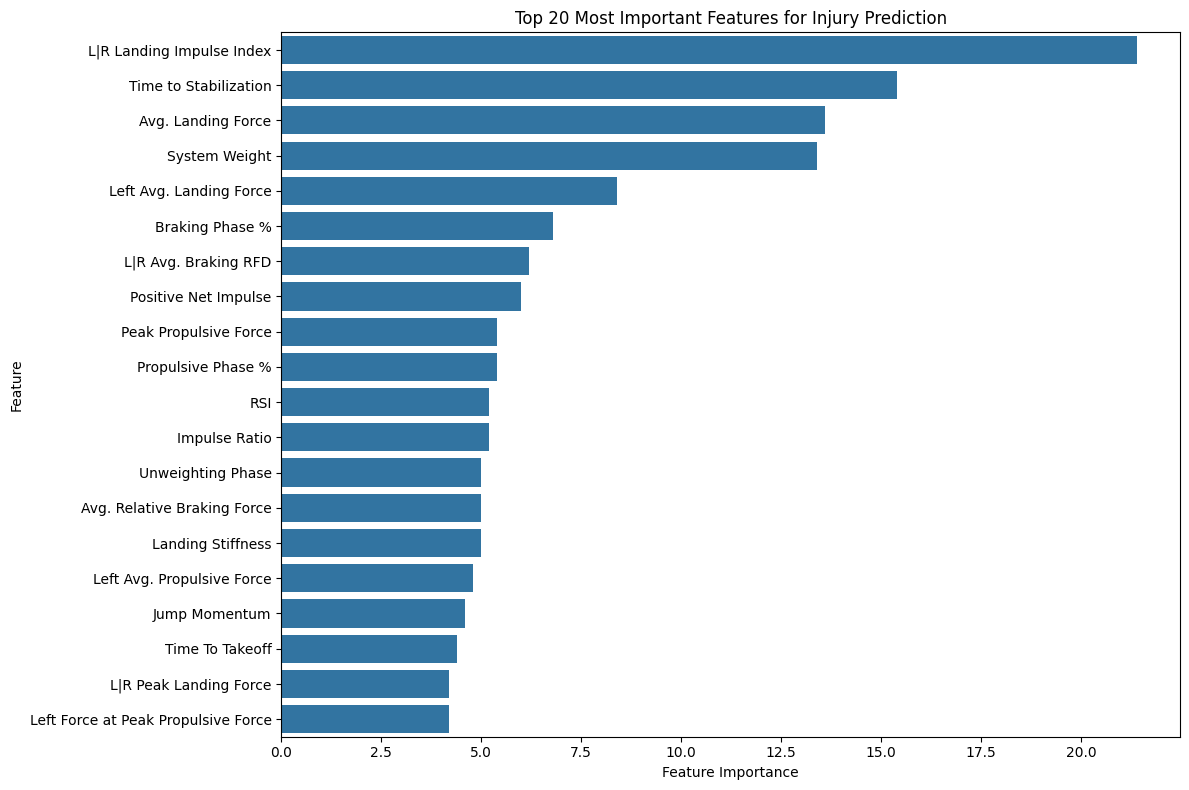

In [5]:
def prepare_data(df):
    date_columns = ['Date', 'problem_date', 'return_date', 'reported_date']
    
    df = df.dropna(subset=date_columns)
    
    for col in date_columns:
        df.loc[:,col] = [parser.parse(date) for date in df[col]]
    
    df = df.sort_values('Date')
    
    # Create injury indicator (1 if injury occurred within next 14 days)
    df['next_injury'] = 0
    for idx, row in df.iterrows():
        future_injuries = df[
            (df['problem_date'] > row['Date']) & 
            (df['problem_date'] <= row['Date'] + pd.Timedelta(days=14))
        ]
        if len(future_injuries) > 0:
            df.at[idx, 'next_injury'] = 1
    
    return df

def create_features(df):
    exclude_cols = ['Date', 'problem_date', 'return_date', 'reported_date', 
                   'next_injury', 'athlete_code', 'TestId']
    feature_cols = [col for col in df.columns if col not in exclude_cols and 
                   df[col].dtype in ['float64', 'int64']]
    
    X = df[feature_cols].ffill().replace([np.inf, -np.inf], np.nan).fillna(0)
    y = df['next_injury']
    
    return X, y, feature_cols

def train_and_evaluate_xgb(X, y, feature_cols):
    tscv = TimeSeriesSplit(n_splits=5)
    
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        # L1 regularization parameters
        'alpha': 1.0,  # L1 regularization
        'lambda': 0.0,  # Set L2 to 0 to focus on L1
        'reg_alpha': 1.0,
        'reg_lambda': 0.0,
        'gamma': 0.0,
        'min_child_weight': 1
    }
    
    feature_importances = []
    predictions = []
    actual_values = []
    feature_weights = []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        if np.isnan(X_train_scaled).any() or np.isnan(X_test_scaled).any():
            X_train_scaled = np.nan_to_num(X_train_scaled)
            X_test_scaled = np.nan_to_num(X_test_scaled)
        
        dtrain = xgb.DMatrix(X_train_scaled, label=y_train, feature_names=feature_cols)
        dtest = xgb.DMatrix(X_test_scaled, label=y_test, feature_names=feature_cols)
        
        model = xgb.train(
            xgb_params,
            dtrain,
            num_boost_round=100,
            evals=[(dtrain, 'train'), (dtest, 'test')],
            early_stopping_rounds=10,
            verbose_eval=False
        )
        
        # Get predictions
        pred = model.predict(dtest)
        predictions.extend(pred)
        actual_values.extend(y_test)
        
        # Get feature importance and weights
        importance_scores = model.get_score(importance_type='weight')
        importance_array = np.zeros(len(feature_cols))
        for feat, score in importance_scores.items():
            feat_idx = feature_cols.index(feat)
            importance_array[feat_idx] = score
        
        feature_importances.append(importance_array)
        feature_weights.append(importance_array)
    
    mean_importances = np.mean(feature_importances, axis=0)
    mean_weights = np.mean(feature_weights, axis=0)
    
    # Create results dictionary
    results = {
        'feature_importance': mean_importances,
        'feature_weights': mean_weights,
        'predictions': predictions,
        'actual_values': actual_values,
        'selected_features': np.where(np.abs(mean_weights) > 0)[0],
        'feature_names': feature_cols
    }
    
    return results

def plot_feature_importance(importances, feature_names, top_n=20):
    feat_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    feat_imp = feat_imp.sort_values('Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feat_imp)
    plt.title(f'Top {top_n} Most Important Features for Injury Prediction')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    
    return feat_imp

# Prepare data
df = prepare_data(data)
X, y, feature_cols = create_features(df)

# Train model and get results
results = train_and_evaluate_xgb(X, y, feature_cols)

# Plot feature importance
feat_imp = plot_feature_importance(
    results['feature_importance'], 
    results['feature_names']
)

# Print model performance metrics
print("\nModel Performance:")
print(f"AUC-ROC: {roc_auc_score(results['actual_values'], results['predictions']):.3f}")

# Print selected features
print("\nSelected Features:")
for idx in results['selected_features']:
    print(f"{results['feature_names'][idx]}: {results['feature_weights'][idx]:.4f}")


In [6]:
def train_and_evaluate_lgbm(X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    
    lgb_params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'num_leaves': 31,  # roughly equivalent to max_depth=5
        'learning_rate': 0.1,
        'feature_fraction': 0.8,  # similar to colsample_bytree
        'bagging_fraction': 0.8,  # similar to subsample
        'bagging_freq': 1,
        'verbose': -1,
        'random_state': 42
    }
    
    num_boost_round = 100
    early_stopping_rounds = 10
    
    feature_importances = []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        if np.isnan(X_train_scaled).any() or np.isnan(X_test_scaled).any():
            X_train_scaled = np.nan_to_num(X_train_scaled)
            X_test_scaled = np.nan_to_num(X_test_scaled)
        
        train_data = lgb.Dataset(X_train_scaled, label=y_train)
        valid_data = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data)
        
        model = lgb.train(
            lgb_params,
            train_data,
            num_boost_round=num_boost_round,
            valid_sets=[train_data, valid_data],
            valid_names=['train', 'valid'],
            callbacks=[
                lgb.early_stopping(early_stopping_rounds),
                lgb.log_evaluation(period=-1)
            ]
        )
        
        importance_array = model.feature_importance(importance_type='gain')
        feature_importances.append(importance_array)
    
    mean_importances = np.mean(feature_importances, axis=0)
    
    return mean_importances

In [7]:
def main():
    df = prepare_data(data)

    #df.drop(["Right Avg. Landing Force", "Right Avg. Landing Force"],axis=1, inplace=True)

    X, y, feature_cols = create_features(df)

    #importances = train_and_evaluate(X, y)
    importances = train_and_evaluate_xgb(X, y)
    #importances = train_and_evaluate_lgbm(X, y)

    feat_imp = plot_feature_importance(importances, feature_cols)
    
    return feat_imp

if __name__ == "__main__":
    feature_importance_results = main()
    print("\nTop 10 Most Important Features:")
    print(feature_importance_results.head(10))

TypeError: train_and_evaluate_xgb() missing 1 required positional argument: 'feature_cols'